<a href="https://www.kaggle.com/code/lorenzoarcioni/collaborative-latent-factors-recommending-system?scriptVersionId=219266354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # Collaborative Latent-Factors-Based Filtering for Movie Recommendations

## Introduction

The latent factor approach in recommendation systems utilizes matrix factorization techniques to uncover hidden patterns in user-item interactions. These methods predict user preferences by mapping both users and items to a shared latent space where their interactions can be represented by their proximity or alignment. Latent factor models, such as Singular Value Decomposition (SVD), are widely used in this context.

Key features of the latent factor approach:
- Captures underlying relationships between users and items.
- Handles sparse datasets effectively by reducing dimensionality.
- Improves scalability compared to neighborhood-based methods.

In this notebook, we will explore the latent factor approach to build a movie recommendation system using matrix factorization.

### Mathematical Background

The latent factor approach works by:
- Represent users and items in a shared lower dimensional latent space (i.e., as a vector of latent factors).
- Such vectros are inferred (i.e., learned) from the observed ratings.
- High correlation between user and item latent factors indicates a possible recomendation.
- Map both users and items to the latent space and then predict ratings based on the inner product in the latent space.

So formally we have:
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $\vec x_u \in R^d$ is the latent factor vector for user $u$. Each $\vec x_u[k] \in R$ measure the extent of interest user $u$ has in items exhibiting latent factor $k$.
- $\vec w_i \in R^d$ is the latent factor vector for item $i$. Each $\vec w_i[k] \in R$ measure the extent of interest item $i$ has in users exhibiting latent factor $k$.

Essentially, $d$ hidden features to describe both users and items.

Thus, $r_{u,i}$ is the rating given by user $u$ to item $i$ and $\hat{r}_{u,i} = \vec x_u \cdot \vec w_i = \sum_{k=1}^d \vec x_u[k] \cdot \vec w_i[k]$ is the predicted rating for user $u$ and item $i$.

The problem is to approximate the user-item matrix $M \in \mathbb R^{n \times m}$ with the product of a user latent factor matrix $X \in \mathbb R^{n \times d}$ and an item latent factor matrix $W^T \in \mathbb R^{d \times m}$. So

$$
M \approx X \cdot W^T.
$$

## Dataset Description

We use two datasets for this analysis:

1. **Movies Dataset**:
   - `Movie_ID`: Unique identifier for each movie.
   - `Title`: Name of the movie.
   - `Year`: Year the movie was released.

2. **Ratings Dataset**:
   - `User_ID`: Unique identifier for each user.
   - `Movie_ID`: Identifier for the movie rated by the user.
   - `Rating`: Numeric rating provided by the user (e.g., on a scale of 1-5).

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# Load the datasets
movies_file = "/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Movie.csv"
ratings_file = "/kaggle/input/netflix-movie-rating-dataset/Netflix_Dataset_Rating.csv"

ratings = pd.read_csv(ratings_file)  # Columns: User_ID, Rating, Movie_ID
movies  = pd.read_csv(movies_file)    # Columns: Movie_ID, Year, Name

### Formal Definition

- $U = \{u_1, u_2, \dots, u_n\}$ is the set of users.
- $U_i = \{u \in U \mid r_{u,i} \neq 0\}$ is the set of users who have rated item $i$
- $I = \{i_1, i_2, \dots, i_m\}$ is the set of items.
- $I_u = \{i \in I \mid r_{u,i} \neq 0\}$ is the set of items rated by user $u$
- $R = \{0, 1, \dots, 5\} \lor R = [0, 1]$ is the set of ratings.
- $r_{u,i}$ is the rating given by user $u$ for item $i$ (equal to 0 if not rated).
- $D = \{(u_j, i_j)\}_{j=1}^{N}$ is the set of user-item pairs (our dataset).
- $I_D = \{i \in I \mid \exists (u, i) \in D\}$ is the set of items in the dataset.
- $U_D = \{u \in U \mid \exists (u, i) \in D\}$ is the set of users in the dataset.

## Model-based Collaborative Filtering

### 1. Data Preprocessing
- **User-Item Matrix Creation**: Convert the ratings dataset into a user-item matrix, where rows represent users and columns represent movies. Missing ratings are filled with zeros. Each rating is represented by a number from 1 to 5.
  $$ M[u, i] = r_{u,i} \in R$$
  Where:
  - $u \in U$
  - $i \in I$
  - $r_{u,i}$ is the rating given by user $u$ for movie $i$.

- **Sparse Matrix Conversion**: The dense matrix is converted to a sparse format for memory optimization:
  $$M_{\{\text{sparse}\}} = \text{sparse}(M)$$

In [2]:
# Step 1: Create a user-item matrix
user_item_matrix = ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating')

# Fill missing values with 0 (can use NaN for some algorithms)
user_item_matrix.fillna(0, inplace=True) # It is not the case for this dataset

# Convert the DataFrame to a sparse matrix
sparse_user_item = csr_matrix(user_item_matrix.values)

### 2. Determine the Loss Function and Computing Its Gradient

Assuming we have access to the dataset $D$ of observed ratings, the matrix $M$ is partially known and filled with those observations. To actually learn the latent factors, we need to choose a loss function to optimize. In our case, we choose squared error (SE):

$$
L(X, W) = \frac{1}{2} \left[ \sum_{(u, i) \in D} (r_{u,i} - \hat{r}_{u,i})^2 + \lambda (\sum_{u \in U_D} \|\vec x_u\|^2 + \sum_{i \in I_D} \|\vec w_i\|^2)\right]
$$

Thus, 

$$X^*, W^* = \argmin_{X, W} \ L(X, W).$$

#### Loss Function
The loss function in matrix notation is defined in terms of matrices as:
$$
L(X, W) = \frac{1}{2} \left[ \| M - X W^T \|_F^2 + \lambda \left( \|X\|_F^2 + \|W\|_F^2 \right) \right],
$$
where:
- $M \in \mathbb{R}^{n \times m}$ is the observed rating matrix, with $M_{u,i} = r_{u,i}$ if user $u$ has rated item $i$, and 0 otherwise.
- $X \in \mathbb{R}^{n \times d}$ represents the user latent factors (each row corresponds to a user vector $X_u$).
- $W \in \mathbb{R}^{m \times d}$ represents the item latent factors (each row corresponds to an item vector $W_i$).
- $\| \cdot \|_F$ is the Frobenius norm.

The prediction matrix is:
$$
\hat{M} = X W^T.
$$

The loss consists of:
1. The reconstruction error:
$$
\| M - X W^T \|_F^2 = \sum_{(u, i) \in D} (r_{u,i} - X_u W_i^T)^2.
$$
2. The regularization terms:
$$
\lambda \left( \|X\|_F^2 + \|W\|_F^2 \right).
$$

---

#### Computing the Gradients

##### Gradient with respect to $X$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial X} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T) W.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial X} \frac{\lambda}{2} \|X\|_F^2 = \lambda X.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial X} = -(M - X W^T) W + \lambda X.
$$

---

##### Gradient with respect to $W$

1. Differentiate the reconstruction error term:
$$
\frac{\partial}{\partial W} \frac{1}{2} \| M - X W^T \|_F^2 = -(M - X W^T)^T X.
$$

2. Differentiate the regularization term:
$$
\frac{\partial}{\partial W} \frac{\lambda}{2} \|W\|_F^2 = \lambda W.
$$

3. Combine the two terms:
$$
\frac{\partial L}{\partial W} = -(M - X W^T)^T X + \lambda W.
$$

In [3]:
# Step 2: Creating the matrix M

# Dimensions of the user-item matrix
num_users, num_items = user_item_matrix.shape

# Create a mask for observed entries in R
M = user_item_matrix.values 
mask = M > 0  # Boolean mask for observed entries

### 3. Optimize the Loss Function

#### Stochastic Gradient Descent

In order to optimize the loss function, we use Stochastic Gradient Descent (SGD).

##### 1. Initialization
- Matrices $X$ (users' latent factors) and $W$ (items' latent factors) are initialized randomly with small values.
- $X \in \mathbb{R}^{m \times d}$, where $m$ is the number of users and $d$ is the number of latent factors.
- $W \in \mathbb{R}^{n \times d}$, where $n$ is the number of items.

##### 2. Gradient Computation
- Define the prediction matrix:
  $$
  \hat{M} = X W^T
  $$
- Compute the error matrix (only for observed entries in $M$):
  $$
  E = \begin{cases}
  M_{ui} - \hat{M}_{ui} \quad &\text{if} \ M_{ui} > 0\\
  0 \quad &\text{otherwise}
  \end{cases},
  $$
  where $E_{ui} = 0$ for unobserved entries of $M$.

- Gradients for $X$ and $W$:
  $$
  \nabla_X = - E W + \lambda X
  $$
  $$
  \nabla_W = - E^T X + \lambda W
  $$

##### 3. Updates
- Update the latent factor matrices $X$ and $W$ simultaneously:
  $$
  X \leftarrow X - \eta \nabla_X
  $$
  $$
  W \leftarrow W - \eta \nabla_W
  $$
- Here, $\eta$ is the learning rate.

##### 4. Loss Tracking
- The total loss for each epoch combines the squared error and the regularization terms:
  $$
  L = \| M - X W^T \|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
  $$
- This tracks the reconstruction error and ensures that the latent factor matrices do not grow too large (controlled by the regularization term).

##### 5. Optimization Loop
- Repeat the following steps for a fixed number of epochs or until the loss converges:
  1. Compute the error matrix $E$.
  2. Compute the gradients $\nabla_X$ and $\nabla_W$ using matrix operations.
  3. Update $X$ and $W$ using the gradients.
  4. Track and print the loss for each epoch.

---

##### Notes
- This implementation only updates $X$ and $W$ for the observed entries of $M$ using matrix masking.
- The hyperparameters ($\eta$, $d$, and $\lambda$) should be tuned based on the dataset for optimal performance.

In [4]:
!pip install tqdm_joblib

In [5]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib  # Per gestire le barre di avanzamento con joblib

# Set the numpy seed
np.random.seed(42)

# Hyperparameters
num_factors = 300  # Number of latent factors (k)
reg_lambda = 0.0001  # Regularization term (lambda)
gradient_clip = 10.0  # Gradient clipping threshold
num_epochs = 25 # Number of epochs
learning_rate = 0.001 # Learning rate (eta)

# Initialize X and W with small random values
X = 0.1 * np.random.randn(num_users, num_factors)
W = 0.1 * np.random.randn(num_items, num_factors)

# Loss history
loss_history = []

# Function to compute gradients for a single user (for X) or item (for W)
def compute_gradient_X(u):
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items]  # Subset of W for rated items
    M_rated = M[u, rated_items]  # Subset of M for rated items

    # Compute error and gradient for user u
    E_u = M_rated - X[u, :] @ W_rated.T
    grad = -E_u @ W_rated + reg_lambda * X[u, :]
    return np.clip(grad, -gradient_clip, gradient_clip)

def compute_gradient_W(i):
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users]  # Subset of X for rated users
    M_rated = M[rated_users, i]  # Subset of M for rated users

    # Compute error and gradient for item i
    E_i = M_rated - X_rated @ W[i, :].T
    grad = -E_i.T @ X_rated + reg_lambda * W[i, :]
    return np.clip(grad, -gradient_clip, gradient_clip)

# SGD Loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Compute the predicted matrix
    M_hat = X @ W.T

    # Compute the error matrix for observed entries only
    E = np.multiply(mask, M - M_hat)

    # Parallel computation of gradients with progress bars
    grad_X = np.zeros_like(X)
    grad_W = np.zeros_like(W)

    # Update X with a shared progress bar
    print("  Gradient wrt X...")
    with tqdm_joblib(tqdm(desc="    Users", total=num_users, leave=True, disable=True)) as _:
        grad_X = np.array(
            Parallel(n_jobs=-1)(delayed(compute_gradient_X)(u) for u in range(num_users))
        )

    # Update W with a shared progress bar
    print("  Gradient wrt W...")
    with tqdm_joblib(tqdm(desc="    Items", total=num_items, leave=True, disable=True)) as _:
        grad_W = np.array(
            Parallel(n_jobs=-1)(delayed(compute_gradient_W)(i) for i in range(num_items))
        )

    # Apply updates
    X -= learning_rate * grad_X
    W -= learning_rate * grad_W

    # Compute the total loss
    reconstruction_loss = np.sum(np.multiply(mask, E) ** 2)
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss

    # Append the total loss to the history
    loss_history.append(total_loss)

    # Print the loss for the current epoch
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

    # Debugging: Check mean and std of gradients
    print(f"  Gradient X: mean={np.mean(grad_X):.4f}, std={np.std(grad_X):.4f}")
    print(f"  Gradient W: mean={np.mean(grad_W):.4f}, std={np.std(grad_W):.4f}")

# Salvataggio delle matrici X e W in formato .npy
np.save("X_matrix_sgd.npy", X)
np.save("W_matrix_sgd.npy", W)

/usr/local/lib/python3.10/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Epoch 1/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 243626310.1290
  Regularization Loss: 43.4087
  Total Loss: 243626353.5377
  Gradient X: mean=0.0758, std=4.0526
  Gradient W: mean=-0.1474, std=8.9375
Epoch 2/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 242017837.6996
  Regularization Loss: 43.5454
  Total Loss: 242017881.2449
  Gradient X: mean=0.0340, std=4.1079
  Gradient W: mean=0.2900, std=9.4772
Epoch 3/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 238911056.2023
  Regularization Loss: 44.0098
  Total Loss: 238911100.2121
  Gradient X: mean=0.1411, std=6.0012
  Gradient W: mean=0.3317, std=9.7081
Epoch 4/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 231730015.0275
  Regularization Loss: 44.9669
  Total Loss: 231730059.9944
  Gradient X: mean=0.2108, std=7.4743
  Gradient W: mean=0.2084, std=9.9048
Epoch 5/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 219051130.1372
  Regularization Loss: 46.5573
  Total Loss: 219051176.6946
  Gradient X: mean=0.2148, std=8.4622
  Gradient W: mean=0.2093, std=9.9569
Epoch 6/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 200657239.4182
  Regularization Loss: 48.8725
  Total Loss: 200657288.2908
  Gradient X: mean=0.2222, std=9.0626
  Gradient W: mean=0.2196, std=9.9777
Epoch 7/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 177157840.8773
  Regularization Loss: 51.9655
  Total Loss: 177157892.8428
  Gradient X: mean=0.2250, std=9.4108
  Gradient W: mean=0.2318, std=9.9867
Epoch 8/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 149736506.3897
  Regularization Loss: 55.8644
  Total Loss: 149736562.2541
  Gradient X: mean=0.2240, std=9.6016
  Gradient W: mean=0.2323, std=9.9905
Epoch 9/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 120039137.7489
  Regularization Loss: 60.5811
  Total Loss: 120039198.3300
  Gradient X: mean=0.2209, std=9.6947
  Gradient W: mean=0.2286, std=9.9925
Epoch 10/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 90116129.1681
  Regularization Loss: 66.1091
  Total Loss: 90116195.2772
  Gradient X: mean=0.2174, std=9.7132
  Gradient W: mean=0.2218, std=9.9941
Epoch 11/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 62398519.9918
  Regularization Loss: 72.3800
  Total Loss: 62398592.3719
  Gradient X: mean=0.2134, std=9.6100
  Gradient W: mean=0.2168, std=9.9916
Epoch 12/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 39683761.9026
  Regularization Loss: 78.8950
  Total Loss: 39683840.7976
  Gradient X: mean=0.2009, std=9.0203
  Gradient W: mean=0.2093, std=9.9725
Epoch 13/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 24844793.8614
  Regularization Loss: 83.5478
  Total Loss: 24844877.4093
  Gradient X: mean=0.1371, std=7.0183
  Gradient W: mean=0.1445, std=9.9118
Epoch 14/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 18079698.1126
  Regularization Loss: 84.9301
  Total Loss: 18079783.0427
  Gradient X: mean=0.0388, std=4.6239
  Gradient W: mean=0.0618, std=9.7455
Epoch 15/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 15431366.1285
  Regularization Loss: 85.8231
  Total Loss: 15431451.9515
  Gradient X: mean=0.0267, std=2.7725
  Gradient W: mean=0.0760, std=9.7207
Epoch 16/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14640305.1978
  Regularization Loss: 85.6687
  Total Loss: 14640390.8665
  Gradient X: mean=-0.0005, std=2.2388
  Gradient W: mean=0.0016, std=9.7896
Epoch 17/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14278365.2185
  Regularization Loss: 86.1912
  Total Loss: 14278451.4097
  Gradient X: mean=0.0060, std=1.7257
  Gradient W: mean=0.0456, std=9.7599
Epoch 18/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 14062380.1533
  Regularization Loss: 85.9775
  Total Loss: 14062466.1308
  Gradient X: mean=-0.0027, std=1.6892
  Gradient W: mean=-0.0321, std=9.8724
Epoch 19/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13947361.3419
  Regularization Loss: 86.5491
  Total Loss: 13947447.8910
  Gradient X: mean=0.0070, std=1.6362
  Gradient W: mean=0.0418, std=9.9167
Epoch 20/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13775872.8080
  Regularization Loss: 86.2732
  Total Loss: 13775959.0812
  Gradient X: mean=-0.0051, std=1.6331
  Gradient W: mean=-0.0362, std=9.9518
Epoch 21/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13688793.8866
  Regularization Loss: 86.8201
  Total Loss: 13688880.7067
  Gradient X: mean=0.0057, std=1.6283
  Gradient W: mean=0.0407, std=9.9531
Epoch 22/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13526957.0242
  Regularization Loss: 86.5114
  Total Loss: 13527043.5356
  Gradient X: mean=-0.0068, std=1.6221
  Gradient W: mean=-0.0348, std=9.9538
Epoch 23/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13445414.6305
  Regularization Loss: 87.0398
  Total Loss: 13445501.6702
  Gradient X: mean=0.0046, std=1.6216
  Gradient W: mean=0.0415, std=9.9547
Epoch 24/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13288119.6311
  Regularization Loss: 86.7175
  Total Loss: 13288206.3486
  Gradient X: mean=-0.0079, std=1.6177
  Gradient W: mean=-0.0318, std=9.9530
Epoch 25/25
  Gradient wrt X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Gradient wrt W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13208193.1545
  Regularization Loss: 87.2406
  Total Loss: 13208280.3952
  Gradient X: mean=0.0040, std=1.6162
  Gradient W: mean=0.0428, std=9.9549


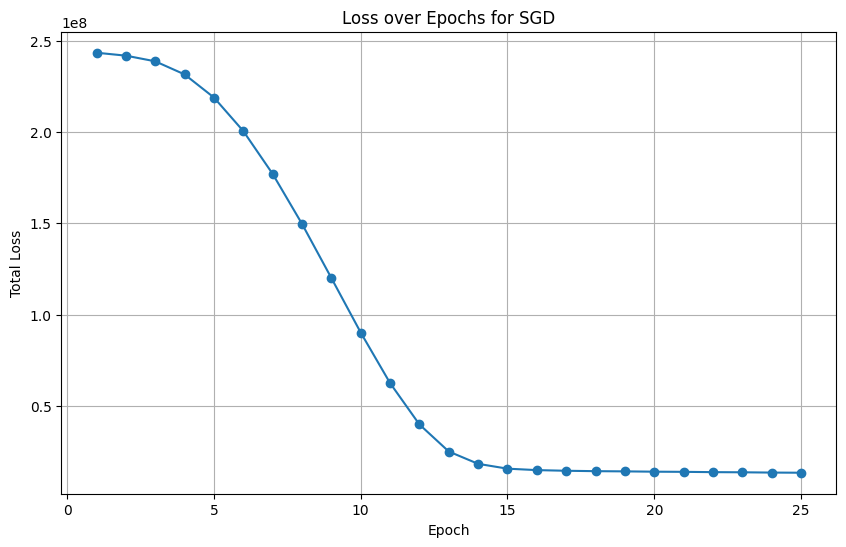

In [6]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for SGD')
plt.grid()
plt.show()

#### Alternating Least Squares (ALS)

Alternating Least Squares (ALS) is an optimization method for matrix factorization that alternates between updating the user latent factors ($X$) and the item latent factors ($W$).

The goal is to minimize the following loss function:
$$
L(X, W) = \|M - XW^T\|_F^2 + \lambda (\|X\|_F^2 + \|W\|_F^2)
$$
Where:
- $M$: User-item interaction matrix.
- $X$: User latent factor matrix ($m \times k$).
- $W$: Item latent factor matrix ($n \times k$).
- $\lambda$: Regularization parameter.

##### ALS Algorithm
1. **Initialization**:
   - Start with random values for $X$ and $W$.
2. **Alternating Updates**:
   - Fix $W$, solve for $X$:
     $$
     X_u = (W^T W + \lambda I)^{-1} W^T M_u
     $$
   - Fix $X$, solve for $W$:
     $$
     W_i = (X^T X + \lambda I)^{-1} X^T M_i
     $$
3. **Convergence**:
   - Iterate until the loss stabilizes or a set number of epochs is reached.

In [7]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib  # Progress bars synchronized with joblib

# Set the numpy seed
np.random.seed(42)

# Hyperparameters
num_factors = 500  # Number of latent factors (k)
reg_lambda = 0.0001  # Regularization term (lambda)
num_epochs = 65 # Number of epochs

# Initialize X and W with small random values
X = np.random.normal(scale=0.01, size=(num_users, num_factors))
W = np.random.normal(scale=0.01, size=(num_items, num_factors))

# List to store the loss values for each iteration
loss_history = []

def update_user(u, W, M, mask, reg_lambda, num_factors):
    """Update a single user's latent factors."""
    rated_items = mask[u, :]  # Mask for items rated by user u
    W_rated = W[rated_items, :]
    M_rated = M[u, rated_items]
    
    A = W_rated.T @ W_rated + reg_lambda * np.eye(num_factors)
    b = W_rated.T @ M_rated
    return np.linalg.solve(A, b)

def update_item(i, X, M, mask, reg_lambda, num_factors):
    """Update a single item's latent factors."""
    rated_users = mask[:, i]  # Mask for users who rated item i
    X_rated = X[rated_users, :]
    M_rated = M[rated_users, i]
    
    A = X_rated.T @ X_rated + reg_lambda * np.eye(num_factors)
    b = X_rated.T @ M_rated
    return np.linalg.solve(A, b)

# ALS iterations
for iteration in range(num_epochs):
    print(f"Iteration {iteration + 1}/{num_epochs}")
    
    # Update X by fixing W (Parallelized) with synchronized progress bar
    print("  Updating X...")
    with tqdm_joblib(tqdm(desc="    Users", total=num_users, leave=True, disable=True)) as _:
        X = np.array(Parallel(n_jobs=-1)(
            delayed(update_user)(u, W, M, mask, reg_lambda, num_factors) for u in range(num_users)
        ))
    
    # Update W by fixing X (Parallelized) with synchronized progress bar
    print("  Updating W...")
    with tqdm_joblib(tqdm(desc="    Items", total=num_items, leave=True, disable=True)) as _:
        W = np.array(Parallel(n_jobs=-1)(
            delayed(update_item)(i, X, M, mask, reg_lambda, num_factors) for i in range(num_items)
        ))
    
    # Compute the loss
    M_hat = X @ W.T
    reconstruction_loss = np.sum(np.multiply(mask, (M - M_hat) ** 2))
    regularization_loss = reg_lambda * (np.linalg.norm(X, 'fro') ** 2 + np.linalg.norm(W, 'fro') ** 2)
    total_loss = reconstruction_loss + regularization_loss
    
    # Save the loss in history
    loss_history.append(total_loss)
    
    # Print loss for the current iteration
    print(f"  Reconstruction Loss: {reconstruction_loss:.4f}")
    print(f"  Regularization Loss: {regularization_loss:.4f}")
    print(f"  Total Loss: {total_loss:.4f}")

# Salvataggio delle matrici X e W in formato .npy
np.save("X_matrix_als.npy", X)
np.save("W_matrix_als.npy", W)

Iteration 1/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 443436.9995
  Regularization Loss: 827074.6844
  Total Loss: 1270511.6839
Iteration 2/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 149517.7179
  Regularization Loss: 723520.8374
  Total Loss: 873038.5553
Iteration 3/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 85755.7267
  Regularization Loss: 698221.6013
  Total Loss: 783977.3280
Iteration 4/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 58759.4516
  Regularization Loss: 684814.0187
  Total Loss: 743573.4703
Iteration 5/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 43620.0193
  Regularization Loss: 674379.8685
  Total Loss: 717999.8878
Iteration 6/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 34141.4574
  Regularization Loss: 665529.3960
  Total Loss: 699670.8533
Iteration 7/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 27763.7203
  Regularization Loss: 657696.5505
  Total Loss: 685460.2708
Iteration 8/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 23236.6359
  Regularization Loss: 650577.2541
  Total Loss: 673813.8900
Iteration 9/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 19885.0855
  Regularization Loss: 643986.7166
  Total Loss: 663871.8021
Iteration 10/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 17317.2305
  Regularization Loss: 637804.9184
  Total Loss: 655122.1489
Iteration 11/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 15292.8283
  Regularization Loss: 631950.3417
  Total Loss: 647243.1700
Iteration 12/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 13658.0356
  Regularization Loss: 626365.6427
  Total Loss: 640023.6783
Iteration 13/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 12310.7403
  Regularization Loss: 621009.2519
  Total Loss: 633319.9922
Iteration 14/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 11181.0585
  Regularization Loss: 615850.2097
  Total Loss: 627031.2682
Iteration 15/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 10219.8565
  Regularization Loss: 610864.8797
  Total Loss: 621084.7361
Iteration 16/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 9391.7432
  Regularization Loss: 606034.7969
  Total Loss: 615426.5401
Iteration 17/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 8670.6581
  Regularization Loss: 601345.2263
  Total Loss: 610015.8844
Iteration 18/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 8037.0188
  Regularization Loss: 596784.1760
  Total Loss: 604821.1948
Iteration 19/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 7475.8340
  Regularization Loss: 592341.7095
  Total Loss: 599817.5436
Iteration 20/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 6975.4295
  Regularization Loss: 588009.4572
  Total Loss: 594984.8867
Iteration 21/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 6526.5704
  Regularization Loss: 583780.2639
  Total Loss: 590306.8343
Iteration 22/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 6121.8465
  Regularization Loss: 579647.9310
  Total Loss: 585769.7775
Iteration 23/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 5755.2342
  Regularization Loss: 575607.0242
  Total Loss: 581362.2584
Iteration 24/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 5421.7795
  Regularization Loss: 571652.7289
  Total Loss: 577074.5085
Iteration 25/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 5117.3650
  Regularization Loss: 567780.7398
  Total Loss: 572898.1049
Iteration 26/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4838.5357
  Regularization Loss: 563987.1752
  Total Loss: 568825.7109
Iteration 27/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4582.3678
  Regularization Loss: 560268.5101
  Total Loss: 564850.8779
Iteration 28/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4346.3683
  Regularization Loss: 556621.5231
  Total Loss: 560967.8914
Iteration 29/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 4128.3963
  Regularization Loss: 553043.2539
  Total Loss: 557171.6503
Iteration 30/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3926.6022
  Regularization Loss: 549530.9689
  Total Loss: 553457.5711
Iteration 31/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3739.3788
  Regularization Loss: 546082.1327
  Total Loss: 549821.5115
Iteration 32/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3565.3222
  Regularization Loss: 542694.3850
  Total Loss: 546259.7072
Iteration 33/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3403.2007
  Regularization Loss: 539365.5209
  Total Loss: 542768.7217
Iteration 34/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3251.9286
  Regularization Loss: 536093.4748
  Total Loss: 539345.4034
Iteration 35/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 3110.5450
  Regularization Loss: 532876.3060
  Total Loss: 535986.8510
Iteration 36/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2978.1967
  Regularization Loss: 529712.1870
  Total Loss: 532690.3837
Iteration 37/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2854.1230
  Regularization Loss: 526599.3932
  Total Loss: 529453.5162
Iteration 38/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2737.6440
  Regularization Loss: 523536.2936
  Total Loss: 526273.9376
Iteration 39/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2628.1496
  Regularization Loss: 520521.3436
  Total Loss: 523149.4931
Iteration 40/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2525.0911
  Regularization Loss: 517553.0772
  Total Loss: 520078.1683
Iteration 41/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2427.9738
  Regularization Loss: 514630.1017
  Total Loss: 517058.0755
Iteration 42/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2336.3502
  Regularization Loss: 511751.0917
  Total Loss: 514087.4420
Iteration 43/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2249.8149
  Regularization Loss: 508914.7847
  Total Loss: 511164.5996
Iteration 44/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2167.9994
  Regularization Loss: 506119.9761
  Total Loss: 508287.9755
Iteration 45/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2090.5686
  Regularization Loss: 503365.5158
  Total Loss: 505456.0844
Iteration 46/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 2017.2166
  Regularization Loss: 500650.3044
  Total Loss: 502667.5209
Iteration 47/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1947.6638
  Regularization Loss: 497973.2900
  Total Loss: 499920.9538
Iteration 48/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1881.6543
  Regularization Loss: 495333.4652
  Total Loss: 497215.1195
Iteration 49/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1818.9535
  Regularization Loss: 492729.8644
  Total Loss: 494548.8179
Iteration 50/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1759.3458
  Regularization Loss: 490161.5614
  Total Loss: 491920.9072
Iteration 51/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1702.6327
  Regularization Loss: 487627.6669
  Total Loss: 489330.2997
Iteration 52/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1648.6317
  Regularization Loss: 485127.3267
  Total Loss: 486775.9584
Iteration 53/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1597.1739
  Regularization Loss: 482659.7196
  Total Loss: 484256.8934
Iteration 54/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1548.1036
  Regularization Loss: 480224.0553
  Total Loss: 481772.1589
Iteration 55/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1501.2767
  Regularization Loss: 477819.5736
  Total Loss: 479320.8502
Iteration 56/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1456.5596
  Regularization Loss: 475445.5417
  Total Loss: 476902.1013
Iteration 57/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1413.8285
  Regularization Loss: 473101.2538
  Total Loss: 474515.0823
Iteration 58/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1372.9685
  Regularization Loss: 470786.0290
  Total Loss: 472158.9975
Iteration 59/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1333.8727
  Regularization Loss: 468499.2106
  Total Loss: 469833.0834
Iteration 60/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1296.4418
  Regularization Loss: 466240.1646
  Total Loss: 467536.6064
Iteration 61/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1260.5832
  Regularization Loss: 464008.2786
  Total Loss: 465268.8617
Iteration 62/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1226.2105
  Regularization Loss: 461802.9609
  Total Loss: 463029.1714
Iteration 63/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1193.2433
  Regularization Loss: 459623.6396
  Total Loss: 460816.8829
Iteration 64/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1161.6063
  Regularization Loss: 457469.7615
  Total Loss: 458631.3678
Iteration 65/65
  Updating X...


  0%|          | 0/143458 [00:00<?, ?it/s]

  Updating W...


  0%|          | 0/1350 [00:00<?, ?it/s]

  Reconstruction Loss: 1131.2293
  Regularization Loss: 455340.7915
  Total Loss: 456472.0208


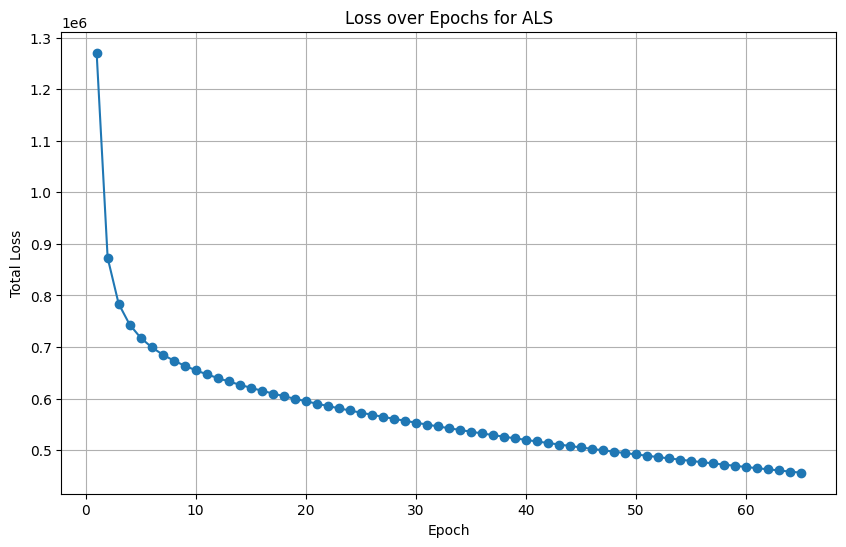

In [8]:
from matplotlib import pyplot as plt

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss over Epochs for ALS')
plt.grid()
plt.show()

In [9]:
def recommend_movies(user_id, M_hat, user_item_matrix, movies, top_n=10):
    """
    Recommends movies for a given user based on the predicted matrix M_hat.

    Parameters:
    - user_id: ID of the user to whom the recommendations will be made.
    - M_hat: Predicted user-item matrix (num_users x num_items).
    - user_item_matrix: Original user-item matrix (Pandas DataFrame) with ratings.
    - movies: DataFrame containing movie details (Movie_ID, Name, Year).
    - top_n: Number of recommendations to return (default is 10).

    Returns:
    - recommendations: DataFrame containing the top_n recommended movies.
    """
    # Map user_id to the corresponding index in M_hat
    user_index = user_item_matrix.index.get_loc(user_id)
    
    # Get the predicted ratings for the user
    predicted_ratings = M_hat[user_index]

    # Get the user's original ratings
    original_ratings = user_item_matrix.loc[user_id]

    # Find movies that the user has not rated (those with a rating of 0)
    unrated_movies = original_ratings[original_ratings == 0].index

    # Map the unrated movies to the correct columns in M_hat
    unrated_predictions = {
        movie_id: predicted_ratings[user_item_matrix.columns.get_loc(movie_id)]
        for movie_id in unrated_movies
    }

    # Sort the predicted ratings for unrated movies in descending order
    sorted_predictions = sorted(unrated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Get the top_n movie IDs
    top_movie_ids = [movie_id for movie_id, _ in sorted_predictions[:top_n]]

    # Retrieve movie details for the top_n recommendations
    recommendations = movies[movies['Movie_ID'].isin(top_movie_ids)]

    # Create a copy of the DataFrame to avoid the SettingWithCopyWarning
    recommendations = recommendations.copy()
    
    # Add the Predicted_Rating column
    recommendations['Predicted_Rating'] = [unrated_predictions[movie_id] for movie_id in recommendations['Movie_ID']]
    
    # Sort recommendations by predicted rating (optional, for clarity)
    recommendations = recommendations.sort_values(by='Predicted_Rating', ascending=False)

    return recommendations[['Movie_ID', 'Name', 'Year', 'Predicted_Rating']]

### 4. Model Testing
The function is tested with a sample user to generate personalized recommendations.

In [10]:
# Step 4: Test the recommendation function
user_id_to_test = 774868  # Select a test user
num_recommendations = 5   # Number of recommendations

try:
    # Exec the recommendation function
    recommendations = recommend_movies(user_id_to_test, M_hat, user_item_matrix, movies, top_n=num_recommendations)
    
    # Show the results
    print(f"Top {num_recommendations} movie recommendations for User {user_id_to_test}:")
    print(recommendations[['Name', 'Year', 'Predicted_Rating', 'Movie_ID']])
except KeyError as e:
    print(f"Error: User ID {user_id_to_test} not found in the dataset.")
except ValueError as e:
    print(f"Error: {e}")

Top 5 movie recommendations for User 774868:
                            Name  Year  Predicted_Rating  Movie_ID
2944                          10  1979          2.701919      2945
2301                    Clockers  1995          2.454914      2302
4247         Conan the Barbarian  1981          2.413732      4248
1209                       Zorro  1981          2.328651      1210
3182  King of the Hill: Season 3  1998          2.294483      3183
